In [1]:
import re
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import requests_cache
from retrying import retry
import openmeteo_requests
import requests, shelve, json, time, unicodedata, os, sys, errno
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# Script pour récupérer les logs de Xiaomi

In [2]:
# Spécifiez ici l'adresse MAC que vous souhaitez suivre
target_mac_addresses = [
    ("A4:C1:38:C9:36:78","Chambre 2"),
    ("A4:C1:38:39:A8:57","Salon")  # Ajoutez d'autres adresses ici
    # "AUTRE_ADRESSE_MAC"
]

In [3]:
data_folder = '/home/pi/CozyTouchAPI//MiTemperature2/data/'

In [4]:
# Lister tous les fichiers dans le dossier
files = os.listdir(data_folder)

# Liste pour stocker les fichiers et leurs timestamps
file_timestamps = []


for file in files:

    # Extraire la partie date_heure du nom de fichier
    # On supprime le préfixe 'data_' et l'extension '.log'
    date_time_str = file[len('data_'):-len('.log')]

    # Définir le format de la date et de l'heure
    date_format = '%Y-%m-%d_%H-%M-%S'

    # Convertir la chaîne en objet datetime
    timestamp = datetime.strptime(date_time_str, date_format)

    file_timestamps.append((file, timestamp))

In [5]:
# Liste pour stocker les résultats
data = []

In [6]:
# Lecture des données dans les fichiers

for filename, time in file_timestamps:
    full_path = os.path.join(data_folder, filename)

    # Ouvrir le fichier en mode lecture
    with open(full_path, 'r') as file:
        lines = file.readlines()  # Lire toutes les lignes du fichier

        # Parcourir les lignes avec leur index
        for i in range(len(lines)):
            # Chercher l'adresse MAC dans la ligne actuelle
            for target_mac_address, room_name in target_mac_addresses:
                if f"{target_mac_address}" in lines[i]:
                    # La ligne suivante contiendra la température et l'humidité
                    if i + 1 < len(lines):  # Vérifiez que la ligne suivante existe
                        temp_line = lines[i + 1]
                        
                        # Chercher la température et l'humidité dans la ligne suivante
                        match = re.search(r"Temperature:\s*([\d.]+)", temp_line)
                        
                        humidity_line = lines[i + 2]
                        match2 = re.search(r"Humidity:\s*(\d+)", humidity_line)

                        # Si une correspondance est trouvée, extraire les données
                        if match:
                            temperature = match.group(1)
                            humidity = match2.group(1)
                            
                            # Ajouter les résultats à la liste
                            data.append({
                                'Timestamp' : time,
                                'Adresse MAC': target_mac_address,
                                'Pièce': room_name,
                                'Température': temperature,
                                'Humidité': humidity
                            })


IndexError: list index out of range

In [7]:
# Créer un DataFrame à partir des données
df = pd.DataFrame(data)
df = df.drop_duplicates(subset=['Adresse MAC', 'Timestamp'])
df = df.sort_values(by='Timestamp')
df['Température'] = pd.to_numeric(df['Température'], errors='coerce')
df['Humidité'] = pd.to_numeric(df['Humidité'], errors='coerce')

print(df)

              Timestamp        Adresse MAC      Pièce  Température  Humidité
227 2024-11-01 19:30:05  A4:C1:38:39:A8:57      Salon         21.2        68
229 2024-11-01 19:30:05  A4:C1:38:C9:36:78  Chambre 2         20.5        64
365 2024-11-01 20:00:04  A4:C1:38:39:A8:57      Salon         21.1        67
363 2024-11-01 20:00:04  A4:C1:38:C9:36:78  Chambre 2         20.6        65
349 2024-11-01 20:30:04  A4:C1:38:39:A8:57      Salon         21.0        68
..                  ...                ...        ...          ...       ...
324 2024-11-03 10:30:07  A4:C1:38:C9:36:78  Chambre 2         20.2        58
290 2024-11-03 11:00:04  A4:C1:38:C9:36:78  Chambre 2         20.3        58
289 2024-11-03 11:00:04  A4:C1:38:39:A8:57      Salon         20.5        62
375 2024-11-03 11:30:05  A4:C1:38:39:A8:57      Salon         20.3        62
376 2024-11-03 11:30:05  A4:C1:38:C9:36:78  Chambre 2         20.2        57

[162 rows x 5 columns]


In [8]:
# Append des données à l'existant

df_hist = pd.read_csv('/home/pi/CozyTouchAPI/data/XiaomiTemperature_data.csv')
df_hist['Timestamp'] = pd.to_datetime(df_hist['Timestamp'])

df_new = pd.concat([df, df_hist], ignore_index=True)

df_new = df_new.drop_duplicates(subset=['Adresse MAC', 'Timestamp'])

# Exporter le DataFrame en fichier CSV
df_new.to_csv('/home/pi/CozyTouchAPI/data/XiaomiTemperature_data.csv', index=False)


In [9]:
# Supprimer les fichiers de plus de un jour

df_cleaning = pd.read_csv('/home/pi/CozyTouchAPI/data/XiaomiTemperature_data.csv')
df_cleaning['Timestamp'] = pd.to_datetime(df_cleaning['Timestamp'])

# Date et heure actuelle
current_date = datetime.now()

# Date et heure d'il y a un jour
yesterday_date = current_date - timedelta(days=1)


for target_timestamp in df_cleaning['Timestamp']:
    if target_timestamp < yesterday_date:
        # Méthode 1 : Recherche exacte
        match_exact = next((file for file, timestamp in file_timestamps if timestamp == target_timestamp), None)
        
        if match_exact:
            full_path = os.path.join(data_folder, match_exact)
            if os.path.exists(full_path):
                print(full_path)
                os.remove(full_path)


/home/pi/CozyTouchAPI//MiTemperature2/data/data_2024-11-01_19-30-05.log
/home/pi/CozyTouchAPI//MiTemperature2/data/data_2024-11-01_20-00-04.log
/home/pi/CozyTouchAPI//MiTemperature2/data/data_2024-11-01_20-30-04.log
/home/pi/CozyTouchAPI//MiTemperature2/data/data_2024-11-01_21-00-05.log
/home/pi/CozyTouchAPI//MiTemperature2/data/data_2024-11-01_21-30-05.log
/home/pi/CozyTouchAPI//MiTemperature2/data/data_2024-11-01_22-00-04.log
/home/pi/CozyTouchAPI//MiTemperature2/data/data_2024-11-01_22-30-04.log
/home/pi/CozyTouchAPI//MiTemperature2/data/data_2024-11-01_23-00-04.log
/home/pi/CozyTouchAPI//MiTemperature2/data/data_2024-11-01_23-30-04.log
/home/pi/CozyTouchAPI//MiTemperature2/data/data_2024-11-02_00-00-04.log
/home/pi/CozyTouchAPI//MiTemperature2/data/data_2024-11-02_00-30-04.log
/home/pi/CozyTouchAPI//MiTemperature2/data/data_2024-11-02_01-00-04.log
/home/pi/CozyTouchAPI//MiTemperature2/data/data_2024-11-02_01-30-04.log
/home/pi/CozyTouchAPI//MiTemperature2/data/data_2024-11-02_02-00

# Agréger les données avec intervales de 30 min

## Fonction pour la temperature de Xiaomi

In [16]:
df = pd.read_csv('/home/pi/CozyTouchAPI/data/XiaomiTemperature_data.csv')

# Convertir la colonne 'Timestamp' en type datetime avant de définir comme index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Vérifier et convertir les types de colonnes si nécessaire
df['Température'] = pd.to_numeric(df['Température'], errors='coerce')
df['Humidité'] = pd.to_numeric(df['Humidité'], errors='coerce')

# Vérification des types de données après conversion
print(df.dtypes)

# Définir 'Timestamp' comme index
df.set_index('Timestamp', inplace=True)

# Agréger les données toutes les 30 minutes en prenant la moyenne et l'écart type, en groupant par 'Pièce' et 'Adresse MAC'
# df_aggregated = df.groupby(['Pièce', 'Adresse MAC']).resample('30min')['Température', 'Humidité'].agg(['mean']).reset_index()

df_aggregated = df.groupby(['Pièce', 'Adresse MAC']).resample('30min').agg(
    moyenne_temperature=('Température', 'mean'),
    ecart_type_temperature=('Température', 'std'),
    moyenne_humid=('Humidité', 'mean'),
    ecart_type_humid=('Humidité', 'std')
).reset_index()
# Afficher le DataFrame agrégé

df_aggregated['moyenne_temperature'] = df_aggregated['moyenne_temperature'].round(2)
df_aggregated['moyenne_humid'] = df_aggregated['moyenne_humid'].round(2)

df_aggregated

Timestamp      datetime64[ns]
Adresse MAC            object
Pièce                  object
Température           float64
Humidité                int64
dtype: object


Pièce        Adresse MAC           Timestamp  moyenne_temperature  \
0    Chambre 2  A4:C1:38:C9:36:78 2024-10-30 14:30:00                20.90   
1    Chambre 2  A4:C1:38:C9:36:78 2024-10-30 15:00:00                20.90   
2    Chambre 2  A4:C1:38:C9:36:78 2024-10-30 15:30:00                21.00   
3    Chambre 2  A4:C1:38:C9:36:78 2024-10-30 16:00:00                21.00   
4    Chambre 2  A4:C1:38:C9:36:78 2024-10-30 16:30:00                20.90   
..         ...                ...                 ...                  ...   
871      Salon  A4:C1:38:39:A8:57 2024-11-08 15:00:00                20.70   
872      Salon  A4:C1:38:39:A8:57 2024-11-08 15:30:00                20.70   
873      Salon  A4:C1:38:39:A8:57 2024-11-08 16:00:00                20.65   
874      Salon  A4:C1:38:39:A8:57 2024-11-08 16:30:00                20.60   
875      Salon  A4:C1:38:39:A8:57 2024-11-08 17:00:00                20.60   

     ecart_type_temperature  moyenne_humid  ecart_type_humid  
0                       NaN          65.00               NaN  
1                       NaN          65.00               NaN  
2                       NaN          65.00               NaN  
3                       NaN          65.00               NaN  
4                       NaN          65.00               NaN  
..                      ...            ...               ...  
871                0.000000          60.33          0.516398  
872                0.000000          61.17          0.408248  
873                0.054772          61.00          0.000000  
874                0.000000          61.00          0.000000  
875                0.000000          61.00          0.000000  

[876 rows x 7 columns]

In [17]:
df_hist_30min = pd.read_csv('/home/pi/CozyTouchAPI/data/XiaomiTemperature30min_data.csv')

df_hist_30min['Timestamp'] = pd.to_datetime(df_hist_30min['Timestamp'])


df_new_30min = pd.concat([df_aggregated, df_hist_30min], ignore_index=False)

df_new_30min = df_new_30min.drop_duplicates(subset=['Timestamp','Pièce'])

df_new_30min = df_new_30min.sort_values(by='Timestamp')

df_new_30min

Pièce        Adresse MAC           Timestamp  moyenne_temperature  \
0    Chambre 2  A4:C1:38:C9:36:78 2024-10-30 14:30:00                20.90   
438      Salon  A4:C1:38:39:A8:57 2024-10-30 14:30:00                20.80   
1    Chambre 2  A4:C1:38:C9:36:78 2024-10-30 15:00:00                20.90   
439      Salon  A4:C1:38:39:A8:57 2024-10-30 15:00:00                20.80   
2    Chambre 2  A4:C1:38:C9:36:78 2024-10-30 15:30:00                21.00   
..         ...                ...                 ...                  ...   
435  Chambre 2  A4:C1:38:C9:36:78 2024-11-08 16:00:00                20.20   
874      Salon  A4:C1:38:39:A8:57 2024-11-08 16:30:00                20.60   
436  Chambre 2  A4:C1:38:C9:36:78 2024-11-08 16:30:00                20.17   
437  Chambre 2  A4:C1:38:C9:36:78 2024-11-08 17:00:00                20.18   
875      Salon  A4:C1:38:39:A8:57 2024-11-08 17:00:00                20.60   

     ecart_type_temperature  moyenne_humid  ecart_type_humid  
0                       NaN          65.00               NaN  
438                     NaN          70.00               NaN  
1                       NaN          65.00               NaN  
439                     NaN          70.00               NaN  
2                       NaN          65.00               NaN  
..                      ...            ...               ...  
435                 0.00000          61.33          0.516398  
874                 0.00000          61.00          0.000000  
436                 0.05164          60.67          0.516398  
437                 0.05000          60.00          0.000000  
875                 0.00000          61.00          0.000000  

[876 rows x 7 columns]

In [18]:
# Exporter le DataFrame en fichier CSV
df_new_30min.to_csv('/home/pi/CozyTouchAPI/data/XiaomiTemperature30min_data.csv', index=False)

In [20]:
# Suppression des données détaillées de plus d'une semaine

# Calculer la date une semaine avant la date actuelle
one_week_ago = datetime.now() - timedelta(weeks=1)

# Filtrer pour ne garder que les lignes dont l'index est postérieur à one_week_ago
df_filtered = df[df.index > one_week_ago]

df_filtered.to_csv('/home/pi/CozyTouchAPI/data/XiaomiTemperature_data.csv', index=True)

## Fonction pour le Cozytouch

In [14]:
df = pd.read_csv('/home/pi/CozyTouchAPI/data/CozyTouch_data.csv')

In [6]:
df.dtypes


piece                 object
temperature          float64
temperature cible    float64
consommation           int64
dtype: object

In [15]:
# Convertir la colonne 'Timestamp' en type datetime avant de définir comme index
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Définir 'Timestamp' comme index
df.set_index('timestamp', inplace=True)

df_aggregated = df.groupby(['piece']).resample('30min').agg(
    moyenne_temperature=('temperature', 'mean'),
    ecart_type_temperature=('temperature', 'std'),
    temperature_cible=('temperature cible', 'mean'),
    consommation=('consommation', 'max')
).reset_index()
# Afficher le DataFrame agrégé

df_aggregated['moyenne_temperature'] = df_aggregated['moyenne_temperature'].round(2)

df_aggregated

piece           timestamp  moyenne_temperature  \
0     Chambre 1 2024-11-01 18:00:00                17.93   
1     Chambre 1 2024-11-01 18:30:00                18.13   
2     Chambre 1 2024-11-01 19:00:00                18.03   
3     Chambre 1 2024-11-01 19:30:00                18.03   
4     Chambre 1 2024-11-01 20:00:00                18.01   
...         ...                 ...                  ...   
1339      Salon 2024-11-08 15:30:00                19.52   
1340      Salon 2024-11-08 16:00:00                19.49   
1341      Salon 2024-11-08 16:30:00                19.48   
1342      Salon 2024-11-08 17:00:00                19.49   
1343      Salon 2024-11-08 17:30:00                19.51   

      ecart_type_temperature  temperature_cible  consommation  
0                        NaN               18.0      260000.0  
1                        NaN               18.0      260000.0  
2                        NaN               18.0      260000.0  
3                        NaN               18.0      260000.0  
4                        NaN               18.0      260000.0  
...                      ...                ...           ...  
1339                0.022509               19.5     1980000.0  
1340                0.027325               19.5     1980000.0  
1341                0.017889               19.5     1980000.0  
1342                0.013663               19.5     1980000.0  
1343                     NaN               19.5     1980000.0  

[1344 rows x 6 columns]

In [10]:
df_hist_30min = pd.read_csv('/home/pi/CozyTouchAPI/data/CozyTouch30min_data.csv')

df_hist_30min['timestamp'] = pd.to_datetime(df_hist_30min['timestamp'])


df_new_30min = pd.concat([df_aggregated, df_hist_30min], ignore_index=False)

df_new_30min = df_new_30min.drop_duplicates(subset=['timestamp','piece'])

df_new_30min = df_new_30min.sort_values(by='timestamp')

df_new_30min

piece           timestamp  moyenne_temperature  \
0     Chambre 1 2024-10-26 17:30:00                19.63   
625   Chambre 2 2024-10-26 17:30:00                19.97   
1875      Salon 2024-10-26 17:30:00                19.72   
1250     Entrée 2024-10-26 17:30:00                19.37   
626   Chambre 2 2024-10-26 18:00:00                19.94   
...         ...                 ...                  ...   
623   Chambre 1 2024-11-08 17:00:00                19.46   
1249  Chambre 2 2024-11-08 17:30:00                18.91   
624   Chambre 1 2024-11-08 17:30:00                19.47   
1874     Entrée 2024-11-08 17:30:00                19.49   
2499      Salon 2024-11-08 17:30:00                19.51   

      ecart_type_temperature  temperature_cible  consommation  
0                   0.005477               18.0      260000.0  
625                 0.010954               18.0      430000.0  
1875                0.000000               18.0     1961000.0  
1250                0.005477               17.2     1216000.0  
626                 0.007071               18.0      430000.0  
...                      ...                ...           ...  
623                 0.013663               19.5      268000.0  
1249                     NaN               19.0      441000.0  
624                      NaN               19.5      268000.0  
1874                     NaN               19.5     1222000.0  
2499                     NaN               19.5     1980000.0  

[2500 rows x 6 columns]

In [11]:
# Exporter le DataFrame en fichier CSV
df_new_30min.to_csv('/home/pi/CozyTouchAPI/data/CozyTouch30min_data.csv', index=False)

In [13]:
# Suppression des données détaillées de plus d'une semaine

# Calculer la date une semaine avant la date actuelle
one_week_ago = datetime.now() - timedelta(weeks=1)

# Filtrer pour ne garder que les lignes dont l'index est postérieur à one_week_ago
df_filtered = df[df.index > one_week_ago]

df_filtered.to_csv('/home/pi/CozyTouchAPI/data/CozyTouch_data.csv', index=True)

### Récupérer dernière écriture CozyTouch

In [60]:
df = pd.read_csv('/home/pi/CozyTouchAPI/data/CozyTouch_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')
df[df['piece'] == 'Chambre 2']['temperature cible'].iloc[-1]

np.float64(18.5)

# Récupération des données Météo API

In [28]:
# Configurer la session de cache
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)

# Configurer le retry avec urllib3 pour le réessai automatique
retry_strategy = Retry(
    total=5,
    backoff_factor=0.2,
    status_forcelist=[429, 500, 502, 503, 504]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
cache_session.mount("https://", adapter)
cache_session.mount("http://", adapter)

openmeteo = openmeteo_requests.Client(session=cache_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"

params = {
	"latitude": 48.8574,
	"longitude": 2.3795,
	"minutely_15": ["temperature_2m", "sunshine_duration", "shortwave_radiation", "direct_radiation"],
	"timezone": "Europe/Berlin",
	"past_days": 1,
	"past_minutely_15": 96,
	"forecast_days": 1,
	"forecast_minutely_15": 96
}

responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process minutely_15 data. The order of variables needs to be the same as requested.
minutely_15 = response.Minutely15()
minutely_15_temperature_2m = minutely_15.Variables(0).ValuesAsNumpy()
minutely_15_sunshine_duration = minutely_15.Variables(1).ValuesAsNumpy()
minutely_15_shortwave_radiation = minutely_15.Variables(2).ValuesAsNumpy()
minutely_15_direct_radiation = minutely_15.Variables(3).ValuesAsNumpy()

minutely_15_data = {"date": pd.date_range(
	start = pd.to_datetime(minutely_15.Time(), unit = "s", utc = True).tz_convert("Europe/Paris"),
	end = pd.to_datetime(minutely_15.TimeEnd(), unit = "s", utc = True).tz_convert("Europe/Paris"),
	freq = pd.Timedelta(seconds = minutely_15.Interval()),
	inclusive = "left"
)}
minutely_15_data["temperature_2m"] = minutely_15_temperature_2m
minutely_15_data["sunshine_duration"] = minutely_15_sunshine_duration
minutely_15_data["shortwave_radiation"] = minutely_15_shortwave_radiation
minutely_15_data["direct_radiation"] = minutely_15_direct_radiation

minutely_15_dataframe = pd.DataFrame(data = minutely_15_data)
minutely_15_dataframe



Coordinates 48.86000061035156°N 2.3799996376037598°E
Elevation 43.0 m asl
Timezone b'Europe/Berlin' b'CET'
Timezone difference to GMT+0 3600 s


date  temperature_2m  sunshine_duration  \
0   2025-01-05 20:30:00+01:00           11.60                0.0   
1   2025-01-05 20:45:00+01:00           11.45                0.0   
2   2025-01-05 21:00:00+01:00           11.40                0.0   
3   2025-01-05 21:15:00+01:00           11.45                0.0   
4   2025-01-05 21:30:00+01:00           11.55                0.0   
..                        ...             ...                ...   
187 2025-01-07 19:15:00+01:00            4.45                0.0   
188 2025-01-07 19:30:00+01:00            4.35                0.0   
189 2025-01-07 19:45:00+01:00            4.30                0.0   
190 2025-01-07 20:00:00+01:00            4.25                0.0   
191 2025-01-07 20:15:00+01:00            4.15                0.0   

     shortwave_radiation  direct_radiation  
0                    0.0               0.0  
1                    0.0               0.0  
2                    0.0               0.0  
3                    0.0               0.0  
4                    0.0               0.0  
..                   ...               ...  
187                  0.0               0.0  
188                  0.0               0.0  
189                  0.0               0.0  
190                  0.0               0.0  
191                  0.0               0.0  

[192 rows x 5 columns]

In [29]:
minutely_15_dataframe.set_index('date', inplace=True)

# Faire un resample toutes les 30 minutes avec une agrégation personnalisée
df_30min = minutely_15_dataframe.resample('30T').agg({
    'temperature_2m': 'mean',           # Moyenne des températures
    'sunshine_duration': 'sum',         # Somme de la durée d'ensoleillement
    'shortwave_radiation': 'sum',       # Somme de la radiation à ondes courtes
    'direct_radiation': 'sum'           # Somme de la radiation directe
})

df_30min['temperature_2m'] = df_30min['temperature_2m'].round(2)

/tmp/ipykernel_4113075/2858856912.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = minutely_15_dataframe.resample('30T').agg({


In [5]:
df_hist_30min = pd.read_csv('/home/pi/CozyTouchAPI/data/MeteoAPI30min.csv')

df_hist_30min['date'] = pd.to_datetime(df_hist_30min['date'])
df_hist_30min.set_index('date', inplace=True)

df_new_30min = pd.concat([df_30min, df_hist_30min], ignore_index=False)

df_new_30min = df_new_30min.reset_index().drop_duplicates(subset=['date'])

df_new_30min = df_new_30min.sort_values(by='date')

# Exporter le DataFrame en fichier CSV
df_new_30min.to_csv('/home/pi/CozyTouchAPI/data/MeteoAPI30min.csv', index=False)

### Récupérer dernière info météo température

In [64]:
df_hist_30min = pd.read_csv('/home/pi/CozyTouchAPI/data/MeteoAPI30min.csv')

df_hist_30min['date'] = pd.to_datetime(df_hist_30min['date'])

df_hist_30min = df_hist_30min.sort_values(by='date')

df_hist_30min['temperature_2m'].iloc[-1].round(1)

np.float64(8.7)

# Graphiques avec les températures

In [19]:
df = pd.read_csv('/home/pi/CozyTouchAPI/data/XiaomiTemperature_data.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])


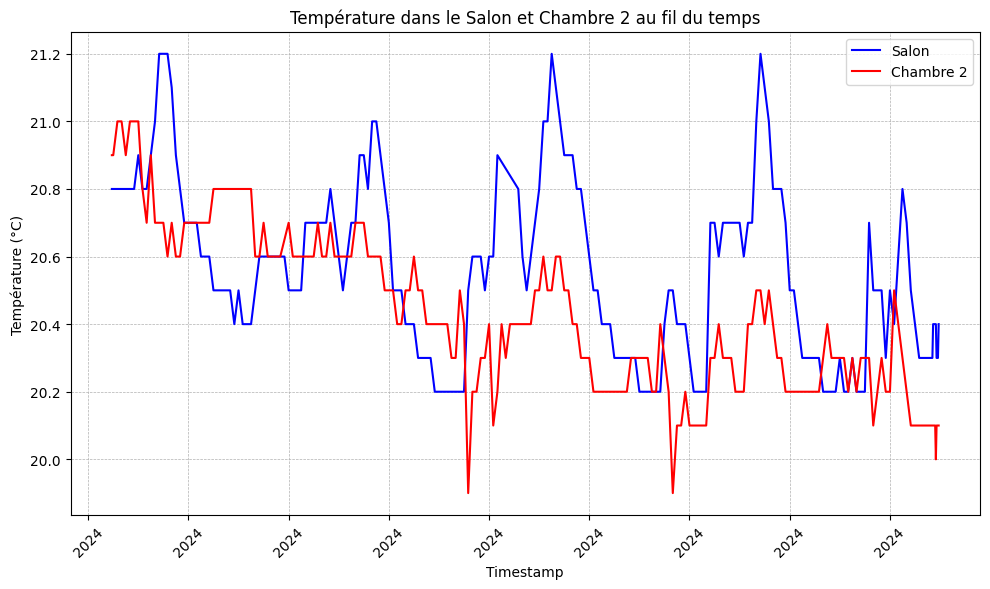

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filtrer les données pour le Salon et la Chambre
df_salon = df[df['Pièce'] == 'Salon']
df_chambre = df[df['Pièce'] == 'Chambre 2']

# Tracer le graphique de la température en fonction du temps
plt.figure(figsize=(10, 6))
plt.plot(df_salon['Timestamp'], df_salon['Température'], linestyle='-', color='b', label='Salon')
plt.plot(df_chambre['Timestamp'], df_chambre['Température'], linestyle='-', color='r', label='Chambre 2')

# Personnaliser le graphique
plt.title("Température dans le Salon et Chambre 2 au fil du temps")
plt.xlabel("Timestamp")
plt.ylabel("Température (°C)")
plt.xticks(rotation=45)

# Utiliser AutoDateLocator et AutoDateFormatter
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.AutoDateFormatter(mdates.AutoDateLocator()))

plt.legend()
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

# Afficher le graphique
plt.tight_layout()
plt.show()

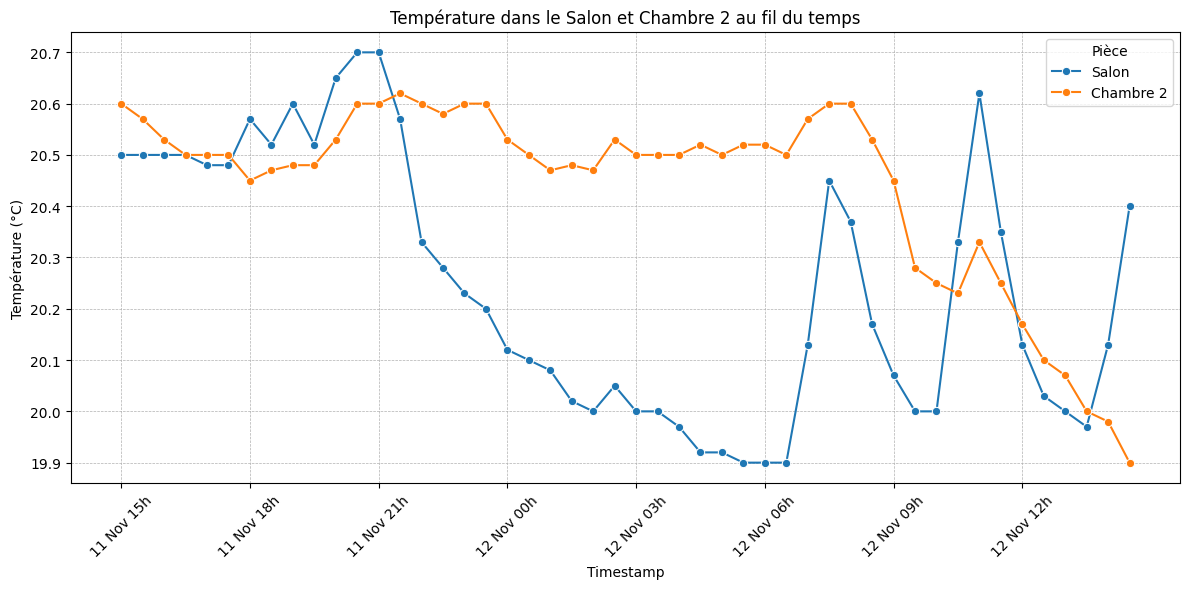

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv('/home/pi/CozyTouchAPI/data/XiaomiTemperature30min_data.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])


# Calculer l'heure de début : 24 heures avant maintenant, arrondie au quart de cadran précédent
start_time = (datetime.now() - timedelta(days=1)).replace(minute=0, second=0, microsecond=0)
quarter_hour = start_time.hour % 3
start_time = start_time - timedelta(hours=quarter_hour)

# Supposons que df est déjà défini avec des données et que les colonnes sont correctes.
df_salon = df[(df['Pièce'] == 'Salon') & (df['Timestamp'] > start_time)]
df_chambre = df[(df['Pièce'] == 'Chambre 2') & (df['Timestamp'] > start_time)]


# Combiner les deux DataFrames pour une visualisation avec Seaborn

df_combined = pd.concat([df_salon, df_chambre])

# Tracer le graphique avec Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined, x='Timestamp', y='moyenne_temperature', hue='Pièce', marker='o')

# Personnaliser le graphique
plt.title("Température dans le Salon et Chambre 2 au fil du temps")
plt.xlabel("Timestamp")
plt.ylabel("Température (°C)")
plt.xticks(rotation=45)


# Configurer les jalons spécifiques pour l'axe des X
# Définir les positions des ticks : minuit, 6h, 12h et 18h
tick_positions = pd.date_range(start=df_combined['Timestamp'].min(), 
                                end=df_combined['Timestamp'].max(), 
                                freq='3h')

# Appliquer les positions de ticks sur l'axe des X
plt.gca().set_xticks(tick_positions)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Hh'))  # Format : jour, mois et heure


plt.legend(title='Pièce')
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

# Afficher le graphique
plt.tight_layout()
plt.show()

In [67]:
df = pd.read_csv('/home/pi/CozyTouchAPI/data/XiaomiTemperature30min_data.csv')
df['timestamp'] = pd.to_datetime(df['Timestamp'])


# Calculer l'heure de début : 24 heures avant maintenant, arrondie au quart de cadran précédent
start_time = (datetime.now() - timedelta(days=1)).replace(minute=0, second=0, microsecond=0)
quarter_hour = start_time.hour % 3
start_time = start_time - timedelta(hours=quarter_hour)

# Supposons que df est déjà défini avec des données et que les colonnes sont correctes.
df_salon = df[(df['Pièce'] == 'Salon') & (df['timestamp'] > start_time)]

dfCozyTouch30min = pd.read_csv('/home/pi/CozyTouchAPI/data/CozyTouch30min_data.csv')
dfCozyTouch30min['timestamp'] = pd.to_datetime(dfCozyTouch30min['timestamp'])
dfCozyTouch24hSalon = dfCozyTouch30min[(dfCozyTouch30min['piece'] == 'Salon') & (dfCozyTouch30min['timestamp'] > start_time)]

df_merged = pd.merge(df_salon, dfCozyTouch24hSalon, on='timestamp', how='inner')

df_merged['temp_ecart'] = df_merged['moyenne_temperature_x'] - df_merged['moyenne_temperature_y']

In [52]:
df_merged.dtypes

Pièce                               object
Adresse MAC                         object
Timestamp                           object
moyenne_temperature_x              float64
ecart_type_temperature_x           float64
moyenne_humid                      float64
ecart_type_humid                   float64
timestamp                   datetime64[ns]
piece                               object
moyenne_temperature_y              float64
ecart_type_temperature_y           float64
temperature_cible                  float64
consommation                       float64
temp_ecart                         float64
dtype: object

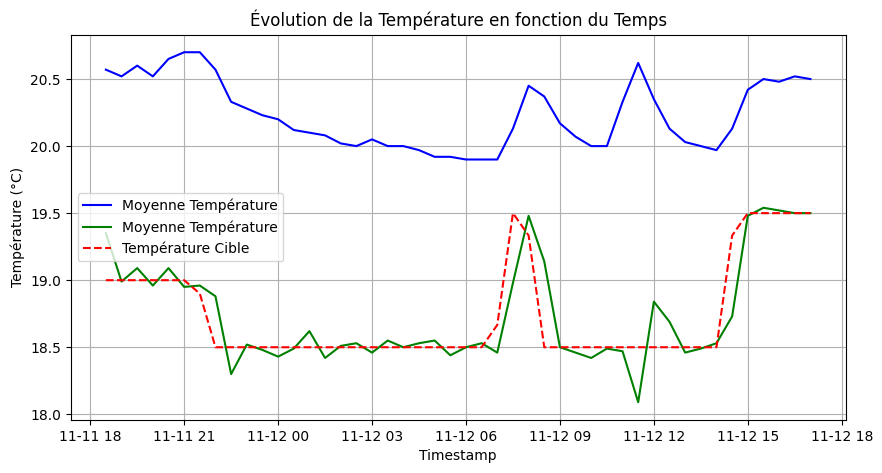

In [70]:
import pandas as pd
import matplotlib.pyplot as plt



# Création du graphique
plt.figure(figsize=(10, 5))

# Tracé des lignes pour moyenne_temperature et temperature_cible
plt.plot(df_merged['timestamp'], df_merged['moyenne_temperature_x'], label='Moyenne Température', color='blue')
plt.plot(df_merged['timestamp'], df_merged['moyenne_temperature_y'], label='Moyenne Température', color='green')
plt.plot(df_merged['timestamp'], df_merged['temperature_cible'], label='Température Cible', color='red', linestyle='--')

# Configuration des axes et du titre
plt.xlabel('Timestamp')
plt.ylabel('Température (°C)')
plt.title('Évolution de la Température en fonction du Temps')
plt.legend()
plt.grid(True)

# Affichage du graphique
plt.show()

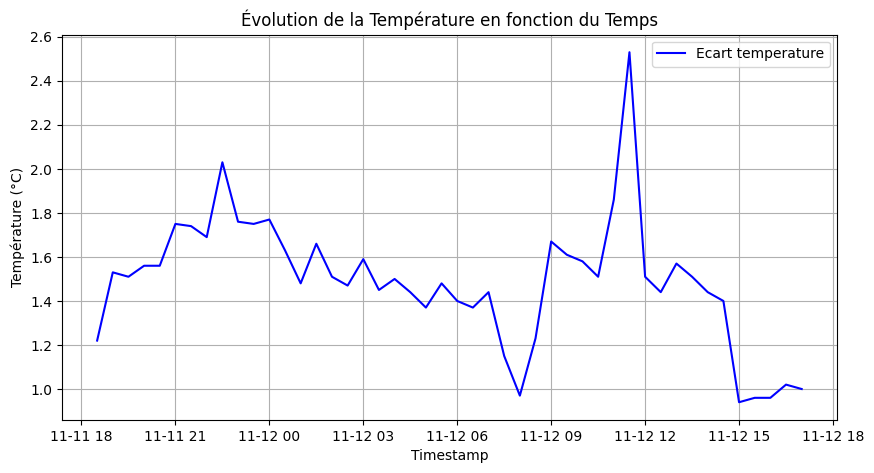

In [69]:
# Création du graphique
plt.figure(figsize=(10, 5))

# Tracé des lignes pour moyenne_temperature et temperature_cible
plt.plot(df_merged['timestamp'], df_merged['temp_ecart'], label='Ecart temperature', color='blue')

# Configuration des axes et du titre
plt.xlabel('Timestamp')
plt.ylabel('Température (°C)')
plt.title('Évolution de la Température en fonction du Temps')
plt.legend()
plt.grid(True)

# Affichage du graphique
plt.show()

# Création de la base de donnée et des gestions

In [2]:
from sqlalchemy import create_engine, inspect, Column, String, Integer, MetaData, Table, DateTime
from sqlalchemy.orm import declarative_base
from sqlalchemy import Column, Integer, String, Float, ForeignKey, Table
from sqlalchemy.orm import sessionmaker, relationship, backref
from sqlalchemy import exc
from sqlalchemy.sql import func
from sqlalchemy.dialects.sqlite import insert
from sqlalchemy import UniqueConstraint

In [3]:
engine = create_engine('sqlite:///data/Thermometer.db')

In [4]:
# Définir une base pour les modèles
Base = declarative_base()

In [5]:
class MeteoAPI30min(Base):
    __tablename__ = 'meteo_api_30min'
    date = Column(DateTime, primary_key=True, nullable=False)  # Utiliser `date` comme clé primaire
    temperature_2m = Column(Float, nullable=False)
    sunshine_duration = Column(Float, nullable=False)
    shortwave_radiation = Column(Float, nullable=False)
    direct_radiation = Column(Float, nullable=False)
    

In [6]:
# Définition des modèles Sqlachemy pour Xiaomi Temprature
class XiaomiTemperature(Base):
    __tablename__ = 'xiaomi_temperature'
    id = Column(Integer, primary_key=True, autoincrement=True)
    timestamp = Column(DateTime, nullable=False)
    mac_address = Column(String, nullable=False)
    room = Column(String, nullable=False)
    temperature = Column(Float, nullable=False)
    humidity = Column(Float, nullable=False)

In [7]:
class XiaomiTemperature30minModele(Base):
    __tablename__ = 'xiaomi_temperature_30_min'
    __table_args__ = (UniqueConstraint('timestamp', 'room', name='unique_timestamp_room'),)
    id = Column(Integer, primary_key=True, autoincrement=True)
    timestamp = Column(DateTime, nullable=False)
    room = Column(String, nullable=False)  # Correspond à "Pièce"
    mac_address = Column(String, nullable=False)  # Correspond à "Adresse MAC"
    avg_temperature = Column(Float, nullable=True)  # Correspond à "moyenne_temperature"
    std_temperature = Column(Float, nullable=True)  # Correspond à "ecart_type_temperature"
    avg_humidity = Column(Float, nullable=True)  # Correspond à "moyenne_humid"
    std_humidity = Column(Float, nullable=True)  # Correspond à "ecart_type_humid"

In [8]:
class CozyTouchTemperatureModele(Base):
    __tablename__ = 'cozy_touch_table'

    id = Column(Integer, primary_key=True, autoincrement=True)  # Clé primaire
    timestamp = Column(DateTime, nullable=False)  # Colonne pour la date et l'heure
    piece = Column(String, nullable=False)  # Nom de la pièce
    temperature = Column(Float, nullable=False)  # Température actuelle
    target_temperature = Column(Float, nullable=False)  # Température cible
    consumption = Column(Integer, nullable=False)  # Consommation en unités

    # Définir la contrainte d'unicité sur `timestamp` et `piece`
    __table_args__ = (
        UniqueConstraint('timestamp', 'piece', name='uix_timestamp_piece'),
    )

In [9]:
# Créer toutes les tables définies dans Base
Base.metadata.create_all(engine)

In [10]:
# Configurer une session pour interagir avec la base
Session = sessionmaker(bind=engine)
session = Session()

## Manipulation de la base de données

In [11]:
import sqlite3

In [12]:
# Chemin vers la base de données
db_path = "data/Thermometer.db"

# Connexion à la base de données
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

In [13]:
# Exécuter la requête pour obtenir la liste des tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Afficher les noms des tables
print("Tables dans la base de données :")
for table in tables:
    print(table[0])

Tables dans la base de données :
xiaomi_temperature
meteo_api_30min
xiaomi_temperature_30_min
cozy_touch_table


In [36]:
# Nom de la table à supprimer
table_name = ""

# Supprimer la table
try:
    cursor.execute(f"DROP TABLE IF EXISTS {table_name};")
    conn.commit()
    print(f"La table '{table_name}' a été supprimée avec succès.")
except sqlite3.Error as e:
    print(f"Erreur lors de la suppression de la table : {e}")

La table 'xiaomi_temperature_30_min' a été supprimée avec succès.


## Création base de donnée pour Xiaomi Temperature

In [32]:
# Créer un DataFrame à partir des données
df = pd.DataFrame(data)
df = df.drop_duplicates(subset=['Adresse MAC', 'Timestamp'])
df = df.sort_values(by='Timestamp')
df['Température'] = pd.to_numeric(df['Température'], errors='coerce')
df['Humidité'] = pd.to_numeric(df['Humidité'], errors='coerce')

In [33]:
df = df.rename(columns={
    "Timestamp": "timestamp",
    "Adresse MAC": "mac_address",
    "Pièce": "room",
    "Température": "temperature",
    "Humidité": "humidity"
})

In [29]:
# Insertion dans la base de donnée sqlite sans les doublons
for _, row in df.iterrows():
    exists = session.query(XiaomiTemperature).filter_by(
        timestamp=row['timestamp'],
        mac_address=row['mac_address'],
        room=row['room'],
        temperature=row['temperature'],
        humidity=row['humidity']
    ).first()

    if not exists:
        new_entry = XiaomiTemperature(
            timestamp=row['timestamp'],
            mac_address=row['mac_address'],
            room=row['room'],
            temperature=row['temperature'],
            humidity=row['humidity']
        )
        session.add(new_entry)
        session.commit()  # Commit pour chaque nouvelle entrée


In [34]:
# Exemple : Récupérer toutes les données
records = session.query(XiaomiTemperature).all()
for record in records:
    print(f"{record.timestamp} - {record.mac_address} - {record.room} - Temp: {record.temperature}°C - Hum: {record.humidity}%")


2025-01-10 16:40:04 - A4:C1:38:C9:36:78 - Chambre 2 - Temp: 20.7°C - Hum: 44.0%
2025-01-10 16:40:04 - A4:C1:38:39:A8:57 - Salon - Temp: 20.7°C - Hum: 50.0%
2025-01-10 16:45:04 - A4:C1:38:C9:36:78 - Chambre 2 - Temp: 20.6°C - Hum: 44.0%
2025-01-10 16:45:04 - A4:C1:38:39:A8:57 - Salon - Temp: 20.7°C - Hum: 49.0%
2025-01-10 16:50:04 - A4:C1:38:39:A8:57 - Salon - Temp: 20.7°C - Hum: 50.0%
2025-01-10 16:50:04 - A4:C1:38:C9:36:78 - Chambre 2 - Temp: 20.6°C - Hum: 44.0%
2025-01-10 16:55:03 - A4:C1:38:39:A8:57 - Salon - Temp: 20.7°C - Hum: 49.0%
2025-01-10 16:55:03 - A4:C1:38:C9:36:78 - Chambre 2 - Temp: 20.6°C - Hum: 44.0%
2025-01-10 17:00:04 - A4:C1:38:C9:36:78 - Chambre 2 - Temp: 20.6°C - Hum: 44.0%
2025-01-10 17:00:04 - A4:C1:38:39:A8:57 - Salon - Temp: 20.7°C - Hum: 50.0%
2025-01-10 17:05:04 - A4:C1:38:39:A8:57 - Salon - Temp: 20.7°C - Hum: 49.0%
2025-01-10 17:05:04 - A4:C1:38:C9:36:78 - Chambre 2 - Temp: 20.6°C - Hum: 44.0%
2025-01-10 17:10:04 - A4:C1:38:39:A8:57 - Salon - Temp: 20.7°C -

In [11]:
# Récupérer l'écriture la plus récente pour "Salon"
latest_record_salon = (
    session.query(XiaomiTemperature)
    .filter(XiaomiTemperature.room == "Salon")
    .order_by(XiaomiTemperature.timestamp.desc())  # Trier par timestamp décroissant
    .first()  # Récupérer la première ligne
)

if latest_record_salon:
    print(
        f"{latest_record_salon.timestamp} - {latest_record_salon.mac_address} - {latest_record_salon.room} "
        f"- Temp: {latest_record_salon.temperature}°C - Hum: {latest_record_salon.humidity}%"
    )

2025-01-16 19:45:04 - A4:C1:38:39:A8:57 - Salon - Temp: 20.9°C - Hum: 49.0%


In [12]:
latest_record_chambre2 = (
    session.query(XiaomiTemperature)
    .filter(XiaomiTemperature.room == "Chambre 2")
    .order_by(XiaomiTemperature.timestamp.desc())  # Trier par timestamp décroissant
    .first()  # Récupérer la première ligne
)

In [13]:
latest_record_chambre2.temperature

20.6

## Mise à jour avec Slqachemy de la fonction XiaomiTemperature30min():

### Init Xiaomi Température 30 min dans la base de donnée

In [17]:
df = pd.read_csv('/home/pi/CozyTouchAPI/data/XiaomiTemperature_data.csv')

# Convertir la colonne 'Timestamp' en type datetime avant de définir comme index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Vérifier et convertir les types de colonnes si nécessaire
df['Température'] = pd.to_numeric(df['Température'], errors='coerce')
df['Humidité'] = pd.to_numeric(df['Humidité'], errors='coerce')

# Vérification des types de données après conversion
print(df.dtypes)

# Définir 'Timestamp' comme index
df.set_index('Timestamp', inplace=True)

# Agréger les données toutes les 30 minutes en prenant la moyenne et l'écart type, en groupant par 'Pièce' et 'Adresse MAC'
# df_aggregated = df.groupby(['Pièce', 'Adresse MAC']).resample('30min')['Température', 'Humidité'].agg(['mean']).reset_index()

df_aggregated = df.groupby(['Pièce', 'Adresse MAC']).resample('30min').agg(
    moyenne_temperature=('Température', 'mean'),
    ecart_type_temperature=('Température', 'std'),
    moyenne_humid=('Humidité', 'mean'),
    ecart_type_humid=('Humidité', 'std')
).reset_index()
# Afficher le DataFrame agrégé

df_aggregated['moyenne_temperature'] = df_aggregated['moyenne_temperature'].round(2)
df_aggregated['moyenne_humid'] = df_aggregated['moyenne_humid'].round(2)

df_hist_30min = pd.read_csv('/home/pi/CozyTouchAPI/data/XiaomiTemperature30min_data.csv')

df_hist_30min['Timestamp'] = pd.to_datetime(df_hist_30min['Timestamp'])

df_new_30min = pd.concat([df_aggregated, df_hist_30min], ignore_index=False)

df_new_30min = df_new_30min.drop_duplicates(subset=['Timestamp','Pièce'])

df_new_30min = df_new_30min.sort_values(by='Timestamp')

# Exporter le DataFrame en fichier CSV
df_new_30min.to_csv('/home/pi/CozyTouchAPI/data/XiaomiTemperature30min_data.csv', index=False)

# Suppression des données détaillées de plus d'une semaine

# Calculer la date une semaine avant la date actuelle
one_week_ago = datetime.now() - timedelta(weeks=1)

# Filtrer pour ne garder que les lignes dont l'index est postérieur à one_week_ago
df_filtered = df[df.index > one_week_ago]

df_filtered.to_csv('/home/pi/CozyTouchAPI/data/XiaomiTemperature_data.csv', index=True)

Timestamp      datetime64[ns]
Adresse MAC            object
Pièce                  object
Température           float64
Humidité              float64
dtype: object


In [18]:
df = pd.read_csv('/home/pi/CozyTouchAPI/data/XiaomiTemperature_data.csv')

In [23]:
df.dtypes

Adresse MAC     object
Pièce           object
Température    float64
Humidité       float64
dtype: object

In [15]:
# Charger toutes les données de la table XiaomiTemperature

last_6_hours = datetime.now() - timedelta(hours=6)

results = session.query(XiaomiTemperature).filter(XiaomiTemperature.timestamp >= last_6_hours).all()

data = [
    {
        "Timestamp": row.timestamp,
        "Adresse MAC": row.mac_address,
        "Pièce": row.room,
        "Température": row.temperature,
        "Humidité": row.humidity
    }
    for row in results
]

In [16]:
df = pd.DataFrame(data)

In [17]:
# Définir 'Timestamp' comme index
df.set_index('Timestamp', inplace=True)

# Agréger les données toutes les 30 minutes en prenant la moyenne et l'écart type, en groupant par 'Pièce' et 'Adresse MAC'
# df_aggregated = df.groupby(['Pièce', 'Adresse MAC']).resample('30min')['Température', 'Humidité'].agg(['mean']).reset_index()

df_aggregated = df.groupby(['Pièce', 'Adresse MAC']).resample('30min').agg(
    moyenne_temperature=('Température', 'mean'),
    ecart_type_temperature=('Température', 'std'),
    moyenne_humid=('Humidité', 'mean'),
    ecart_type_humid=('Humidité', 'std')
).reset_index()
# Afficher le DataFrame agrégé

df_aggregated['moyenne_temperature'] = df_aggregated['moyenne_temperature'].round(2)
df_aggregated['moyenne_humid'] = df_aggregated['moyenne_humid'].round(2)

In [20]:
df_aggregated

Pièce        Adresse MAC           Timestamp  moyenne_temperature  \
0   Chambre 2  A4:C1:38:C9:36:78 2025-01-12 12:00:00                20.87   
1   Chambre 2  A4:C1:38:C9:36:78 2025-01-12 12:30:00                20.97   
2   Chambre 2  A4:C1:38:C9:36:78 2025-01-12 13:00:00                21.10   
3   Chambre 2  A4:C1:38:C9:36:78 2025-01-12 13:30:00                21.07   
4   Chambre 2  A4:C1:38:C9:36:78 2025-01-12 14:00:00                20.95   
5   Chambre 2  A4:C1:38:C9:36:78 2025-01-12 14:30:00                20.93   
6   Chambre 2  A4:C1:38:C9:36:78 2025-01-12 15:00:00                20.90   
7   Chambre 2  A4:C1:38:C9:36:78 2025-01-12 15:30:00                20.92   
8   Chambre 2  A4:C1:38:C9:36:78 2025-01-12 16:00:00                21.00   
9   Chambre 2  A4:C1:38:C9:36:78 2025-01-12 16:30:00                21.00   
10  Chambre 2  A4:C1:38:C9:36:78 2025-01-12 17:00:00                20.93   
11  Chambre 2  A4:C1:38:C9:36:78 2025-01-12 17:30:00                20.92   
12  Chambre 2  A4:C1:38:C9:36:78 2025-01-12 18:00:00                21.00   
13      Salon  A4:C1:38:39:A8:57 2025-01-12 12:00:00                20.60   
14      Salon  A4:C1:38:39:A8:57 2025-01-12 12:30:00                20.80   
15      Salon  A4:C1:38:39:A8:57 2025-01-12 13:00:00                21.22   
16      Salon  A4:C1:38:39:A8:57 2025-01-12 13:30:00                20.92   
17      Salon  A4:C1:38:39:A8:57 2025-01-12 14:00:00                20.80   
18      Salon  A4:C1:38:39:A8:57 2025-01-12 14:30:00                20.78   
19      Salon  A4:C1:38:39:A8:57 2025-01-12 15:00:00                20.68   
20      Salon  A4:C1:38:39:A8:57 2025-01-12 15:30:00                20.75   
21      Salon  A4:C1:38:39:A8:57 2025-01-12 16:00:00                20.98   
22      Salon  A4:C1:38:39:A8:57 2025-01-12 16:30:00                21.03   
23      Salon  A4:C1:38:39:A8:57 2025-01-12 17:00:00                21.00   
24      Salon  A4:C1:38:39:A8:57 2025-01-12 17:30:00                20.98   
25      Salon  A4:C1:38:39:A8:57 2025-01-12 18:00:00                20.87   

    ecart_type_temperature  moyenne_humid  ecart_type_humid  
0                 0.057735          39.33          0.577350  
1                 0.103280          41.67          3.076795  
2                 0.000000          48.50          0.836660  
3                 0.051640          48.50          1.378405  
4                 0.054772          45.50          1.048809  
5                 0.051640          46.50          0.836660  
6                 0.000000          47.00          0.000000  
7                 0.040825          47.50          0.547723  
8                 0.000000          48.33          0.516398  
9                 0.000000          48.17          0.983192  
10                0.051640          46.00          0.632456  
11                0.040825          47.00          0.000000  
12                0.000000          47.00          0.000000  
13                0.000000          50.00          0.000000  
14                0.126491          53.67          4.131182  
15                0.075277          58.33          1.505545  
16                0.116905          56.00          0.000000  
17                0.000000          56.00          0.000000  
18                0.040825          55.33          0.516398  
19                0.040825          54.33          0.516398  
20                0.054772          54.67          0.516398  
21                0.116905          56.17          0.408248  
22                0.051640          56.17          0.408248  
23                0.000000          57.00          0.000000  
24                0.040825          56.83          0.408248  
25                0.057735          55.67          0.577350

In [18]:
# Parcourir les lignes du DataFrame
for _, row in df_aggregated.iterrows():
    stmt = insert(XiaomiTemperature30minModele).values(
        timestamp=row["Timestamp"],
        room=row["Pièce"],
        mac_address=row["Adresse MAC"],
        avg_temperature=row["moyenne_temperature"],
        std_temperature=row["ecart_type_temperature"],
        avg_humidity=row["moyenne_humid"],
        std_humidity=row["ecart_type_humid"]
    )
    # En cas de conflit sur (timestamp, room), mettre à jour les autres colonnes
    stmt = stmt.on_conflict_do_update(
        index_elements=["timestamp", "room"],  # Clé unique utilisée pour détecter les conflits
        set_={
            "mac_address": stmt.excluded.mac_address,
            "avg_temperature": stmt.excluded.avg_temperature,
            "std_temperature": stmt.excluded.std_temperature,
            "avg_humidity": stmt.excluded.avg_humidity,
            "std_humidity": stmt.excluded.std_humidity,
        }
    )
    # Exécuter la requête
    session.execute(stmt)

# Commit pour sauvegarder les modifications
session.commit()

In [32]:

# Calculer la limite de 7 jours
seven_days_ago = datetime.now() - timedelta(days=7)

# Supprimer les lignes avec un timestamp plus ancien que 7 jours
try:
    # Filtrer et supprimer
    session.query(XiaomiTemperature).filter(XiaomiTemperature.timestamp < seven_days_ago).delete(synchronize_session=False)
    
    # Commit pour appliquer les changements
    session.commit()
    print("Les lignes de plus de 7 jours ont été supprimées avec succès.")
except Exception as e:
    # En cas d'erreur
    session.rollback()
    print(f"Erreur lors de la suppression : {e}")

Les lignes de plus de 7 jours ont été supprimées avec succès.


In [47]:
for _, row in df_new_30min.iterrows():
    entry = XiaomiTemperature30minModele(
        timestamp=row["Timestamp"],
        room=row["Pièce"],
        mac_address=row["Adresse MAC"],
        avg_temperature=row["moyenne_temperature"],
        std_temperature=row["ecart_type_temperature"],
        avg_humidity=row["moyenne_humid"],
        std_humidity=row["ecart_type_humid"],
    )
    try:
        session.add(entry)
    except Exception as e:
        session.rollback()
        print(f"Erreur lors de l'ajout de l'entrée : {e}")

# Commit pour sauvegarder toutes les insertions
try:
    session.commit()
except Exception as e:
    session.rollback()
    print(f"Erreur lors du commit : {e}")


In [14]:
# Requête pour obtenir toutes les entrées
all_entries = session.query(XiaomiTemperature30minModele).all()

# Afficher les résultats
for entry in all_entries:
    print(f"Timestamp: {entry.timestamp}, Room: {entry.room}, MAC Address: {entry.mac_address}, "
          f"Avg Temp: {entry.avg_temperature}, Std Temp: {entry.std_temperature}, "
          f"Avg Humidity: {entry.avg_humidity}, Std Humidity: {entry.std_humidity}")

Timestamp: 2024-10-30 14:30:00, Room: Salon, MAC Address: A4:C1:38:39:A8:57, Avg Temp: 20.8, Std Temp: None, Avg Humidity: 70.0, Std Humidity: None
Timestamp: 2024-10-30 14:30:00, Room: Chambre 2, MAC Address: A4:C1:38:C9:36:78, Avg Temp: 20.9, Std Temp: None, Avg Humidity: 65.0, Std Humidity: None
Timestamp: 2024-10-30 15:00:00, Room: Salon, MAC Address: A4:C1:38:39:A8:57, Avg Temp: 20.8, Std Temp: None, Avg Humidity: 70.0, Std Humidity: None
Timestamp: 2024-10-30 15:00:00, Room: Chambre 2, MAC Address: A4:C1:38:C9:36:78, Avg Temp: 20.9, Std Temp: None, Avg Humidity: 65.0, Std Humidity: None
Timestamp: 2024-10-30 15:30:00, Room: Chambre 2, MAC Address: A4:C1:38:C9:36:78, Avg Temp: 21.0, Std Temp: None, Avg Humidity: 65.0, Std Humidity: None
Timestamp: 2024-10-30 15:30:00, Room: Salon, MAC Address: A4:C1:38:39:A8:57, Avg Temp: 20.8, Std Temp: None, Avg Humidity: 69.0, Std Humidity: None
Timestamp: 2024-10-30 16:00:00, Room: Chambre 2, MAC Address: A4:C1:38:C9:36:78, Avg Temp: 21.0, Std

In [33]:
# Requête pour obtenir les entrées uniquement pour "Chambre 2"
chambre2_entries = session.query(XiaomiTemperature30minModele).filter(XiaomiTemperature30minModele.room == "Chambre 2").all()

# Afficher les résultats
for entry in chambre2_entries:
    print(f"Timestamp: {entry.timestamp}, Room: {entry.room}, MAC Address: {entry.mac_address}, "
          f"Avg Temp: {entry.avg_temperature}, Std Temp: {entry.std_temperature}, "
          f"Avg Humidity: {entry.avg_humidity}, Std Humidity: {entry.std_humidity}")


Timestamp: 2024-10-30 14:30:00, Room: Chambre 2, MAC Address: A4:C1:38:C9:36:78, Avg Temp: 20.9, Std Temp: None, Avg Humidity: 65.0, Std Humidity: None
Timestamp: 2024-10-30 15:00:00, Room: Chambre 2, MAC Address: A4:C1:38:C9:36:78, Avg Temp: 20.9, Std Temp: None, Avg Humidity: 65.0, Std Humidity: None
Timestamp: 2024-10-30 15:30:00, Room: Chambre 2, MAC Address: A4:C1:38:C9:36:78, Avg Temp: 21.0, Std Temp: None, Avg Humidity: 65.0, Std Humidity: None
Timestamp: 2024-10-30 16:00:00, Room: Chambre 2, MAC Address: A4:C1:38:C9:36:78, Avg Temp: 21.0, Std Temp: None, Avg Humidity: 65.0, Std Humidity: None
Timestamp: 2024-10-30 16:30:00, Room: Chambre 2, MAC Address: A4:C1:38:C9:36:78, Avg Temp: 20.9, Std Temp: None, Avg Humidity: 65.0, Std Humidity: None
Timestamp: 2024-10-30 17:00:00, Room: Chambre 2, MAC Address: A4:C1:38:C9:36:78, Avg Temp: 21.0, Std Temp: None, Avg Humidity: 65.0, Std Humidity: None
Timestamp: 2024-10-30 17:30:00, Room: Chambre 2, MAC Address: A4:C1:38:C9:36:78, Avg Tem

## Création base de donnée pour météo API

### Init MeteoAPI

In [19]:
# Insérer chaque ligne comme une instance du modèle
for _, row in df_new_30min.iterrows():
    entry = MeteoAPI30min(
        date=row["date"],
        temperature_2m=row["temperature_2m"],
        sunshine_duration=row["sunshine_duration"],
        shortwave_radiation=row["shortwave_radiation"],
        direct_radiation=row["direct_radiation"]
    )
    session.add(entry)

# Commit pour sauvegarder les modifications
session.commit()

### Mise à jour de la table avec des nouvelles données

In [33]:
for _, row in df_30min.iterrows():
    stmt = insert(MeteoAPI30min).values(
        date=row["date"],
        temperature_2m=row["temperature_2m"],
        sunshine_duration=row["sunshine_duration"],
        shortwave_radiation=row["shortwave_radiation"],
        direct_radiation=row["direct_radiation"]
    )
    # On conflict, do update
    stmt = stmt.on_conflict_do_update(
        index_elements=["date"],  # Colonne(s) utilisée(s) pour détecter les conflits
        set_={
            "temperature_2m": stmt.excluded.temperature_2m,
            "sunshine_duration": stmt.excluded.sunshine_duration,
            "shortwave_radiation": stmt.excluded.shortwave_radiation,
            "direct_radiation": stmt.excluded.direct_radiation,
        }
    )
    session.execute(stmt)

session.commit()

In [12]:
# Requête pour récupérer toutes les entrées
all_entries = session.query(MeteoAPI30min).all()

# Affichage des données récupérées
for entry in all_entries:
    print(f"Date: {entry.date}, Température: {entry.temperature_2m}, "
          f"Ensoleillement: {entry.sunshine_duration}, Radiation Onde Courte: {entry.shortwave_radiation}, "
          f"Radiation Directe: {entry.direct_radiation}")


Date: 2024-11-06 15:30:00, Température: 11.975000381469728, Ensoleillement: 227.0634765625, Radiation Onde Courte: 200.0, Radiation Directe: 37.0
Date: 2024-11-06 16:00:00, Température: 11.699999809265137, Ensoleillement: 0.0, Radiation Onde Courte: 120.0, Radiation Directe: 14.0
Date: 2024-11-06 16:30:00, Température: 11.5, Ensoleillement: 0.0, Radiation Onde Courte: 70.0, Radiation Directe: 5.0
Date: 2024-11-06 17:00:00, Température: 11.350000381469728, Ensoleillement: 0.0, Radiation Onde Courte: 19.0, Radiation Directe: 1.0
Date: 2024-11-06 17:30:00, Température: 11.149999618530272, Ensoleillement: 0.0, Radiation Onde Courte: 0.0, Radiation Directe: 0.0
Date: 2024-11-06 18:00:00, Température: 10.899999618530272, Ensoleillement: 0.0, Radiation Onde Courte: 0.0, Radiation Directe: 0.0
Date: 2024-11-06 18:30:00, Température: 10.75, Ensoleillement: 0.0, Radiation Onde Courte: 0.0, Radiation Directe: 0.0
Date: 2024-11-06 19:00:00, Température: 10.625, Ensoleillement: 0.0, Radiation Onde 

In [32]:
# Date actuelle
current_date = datetime.now()

# Requête pour trouver la ligne avec la date la plus proche
closest_entry = (
    session.query(MeteoAPI30min)
    .order_by(func.abs(func.julianday(MeteoAPI30min.date) - func.julianday(current_date)))
    .first()
)


# Afficher le résultat
if closest_entry:
    print(f"Date: {closest_entry.date}, Température: {round(closest_entry.temperature_2m,1)}, "
          f"Ensoleillement: {closest_entry.sunshine_duration}, "
          f"Radiation Onde Courte: {closest_entry.shortwave_radiation}, "
          f"Radiation Directe: {closest_entry.direct_radiation}")
else:
    print("Aucune donnée trouvée.")

Date: 2025-01-17 17:00:00, Température: 1.8, Ensoleillement: 0.0, Radiation Onde Courte: 16.0, Radiation Directe: 0.0


# Table pour CozyTouch

## Création du modèle

## Init des données

In [23]:
df = pd.read_csv('/home/pi/CozyTouchAPI/data/CozyTouch_data.csv')

In [24]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [17]:
df.dtypes

timestamp            datetime64[ns]
piece                        object
temperature                 float64
temperature cible           float64
consommation                  int64
dtype: object

In [25]:


for _, row in df.iterrows():
    stmt = insert(CozyTouchTemperatureModele).values(
        timestamp=row['timestamp'],
        piece=row['piece'],
        temperature=row['temperature'],
        target_temperature=row['temperature cible'],
        consumption=row['consommation']
    )

    # En cas de conflit sur `timestamp` et `piece`, ignorer l'insertion
    stmt = stmt.on_conflict_do_nothing(
        index_elements=['timestamp', 'piece']  # Clés utilisées pour détecter le conflit
    )

    session.execute(stmt)

# Commit pour sauvegarder dans la base de données
session.commit()


In [31]:
# Lire toutes les entrées de la table RoomTemperature
all_entries = session.query(CozyTouchTemperatureModele).all()

# Afficher les résultats
for entry in all_entries:
    print(f"Timestamp: {entry.timestamp}, Piece: {entry.piece}, "
          f"Temperature: {entry.temperature}°C, "
          f"Target Temperature: {entry.target_temperature}°C, "
          f"Consumption: {entry.consumption}W")

Timestamp: 2025-01-10 16:10:03.891779, Piece: Salon, Temperature: 20.03°C, Target Temperature: 20.0°C, Consumption: 2404000W
Timestamp: 2025-01-10 16:10:03.891835, Piece: Entrée, Temperature: 19.65°C, Target Temperature: 19.5°C, Consumption: 1397000W
Timestamp: 2025-01-10 16:10:03.891851, Piece: Chambre 1, Temperature: 18.98°C, Target Temperature: 19.0°C, Consumption: 452000W
Timestamp: 2025-01-10 16:10:03.891864, Piece: Chambre 2, Temperature: 19.53°C, Target Temperature: 19.5°C, Consumption: 707000W
Timestamp: 2025-01-10 16:15:03.864811, Piece: Salon, Temperature: 19.99°C, Target Temperature: 20.0°C, Consumption: 2404000W
Timestamp: 2025-01-10 16:15:03.864866, Piece: Entrée, Temperature: 19.58°C, Target Temperature: 19.5°C, Consumption: 1397000W
Timestamp: 2025-01-10 16:15:03.864882, Piece: Chambre 1, Temperature: 18.97°C, Target Temperature: 19.0°C, Consumption: 452000W
Timestamp: 2025-01-10 16:15:03.864895, Piece: Chambre 2, Temperature: 19.48°C, Target Temperature: 19.5°C, Consump

In [35]:
latest_record_cozy_chambre2 = (
    session.query(CozyTouchTemperatureModele)
    .filter(CozyTouchTemperatureModele.piece== "Chambre 2")
    .order_by(CozyTouchTemperatureModele.timestamp.desc())  # Trier par timestamp décroissant
    .first()  # Récupérer la première ligne
)


In [40]:
latest_record_cozy_salon = (
    session.query(CozyTouchTemperatureModele)
    .filter(CozyTouchTemperatureModele.piece== "Salon")
    .order_by(CozyTouchTemperatureModele.timestamp.desc())  # Trier par timestamp décroissant
    .first()  # Récupérer la première ligne
)

In [42]:
latest_record_cozy_salon.target_temperature

19.5